c:\Users\VikA\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


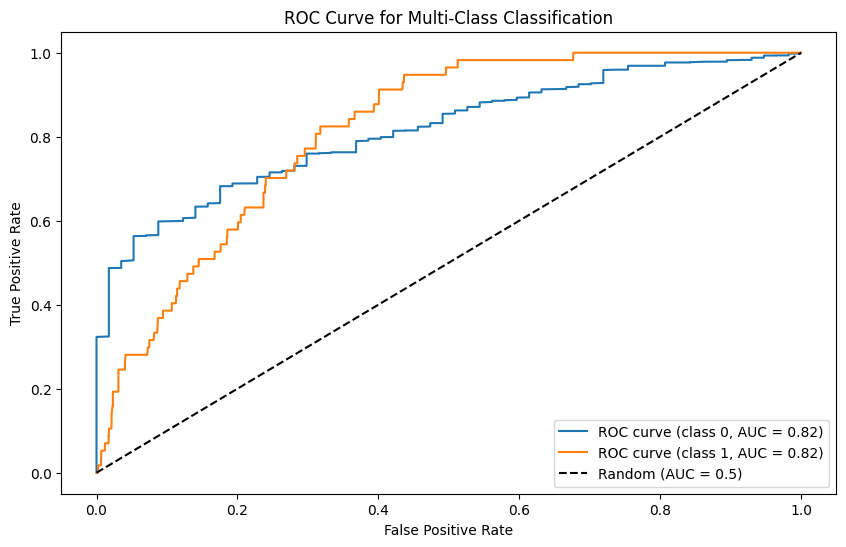

Classification Report:
              precision    recall  f1-score   support

           0       0.02      1.00      0.03        57
           1       0.00      0.00      0.00      3443

    accuracy                           0.02      3500
   macro avg       0.01      0.50      0.02      3500
weighted avg       0.00      0.02      0.00      3500

Confusion Matrix:
[[  57    0]
 [3443    0]]


c:\Users\VikA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\VikA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\VikA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [5]:
import pandas as pd   #Для работы с данными в формате таблиц
from sklearn.model_selection import train_test_split #Для разделения данных на обучающую и тестовую выборки
from sklearn.preprocessing import StandardScaler, LabelEncoder #приведение к нулевому среднему и единичному стандартному отклонению
from sklearn.metrics import roc_curve, auc #Для преобразования категориальных меток в числовые значения
import xgboost as xgb  #Для работы с библиотекой XGBoost,
import matplotlib.pyplot as plt  #Для визуализации данных 
import numpy as np    #Для работы с массивами и численными вычислениями

train_data = pd.read_csv('C:\\Users\\VikA\\Desktop\\интерсив\\cleaned_data.csv') 
valid_data = pd.read_csv('C:\\Users\\VikA\\Desktop\\интерсив\\cleaned_valid.csv') 
# Выбор признаков и целевой переменной
X_train = train_data.drop(columns=['Купоено/Не куплено', 'Уникальный идентификатор покупки'])  # Удаляем ненужные столбцы 
y_train = train_data['Купоено/Не куплено'] #Выбирает столбец Купоено/Не куплено как целевую переменную для обучения

X_valid = valid_data.drop(columns=['Купоено/Не куплено', 'Уникальный идентификатор покупки'])  # Удаляем ненужные столбцы 
y_valid = valid_data['Купоено/Не куплено']
# Преобразование задачи регрессии в задачу классификации
# Разделение на категории (например, низкая, средняя, высокая сумма)
bins = [0, 100, 500, np.inf]  # пределяет границы для разбиения целевой переменной на категории 
labels = [0, 1, 2]  # Метки для категорий
y_cat = pd.cut(y_train, bins=bins, labels=labels)  # Используем y_train вместо y

# Преобразование категорий в числа
le = LabelEncoder()
y_encoded = le.fit_transform(y_cat) #Масштабирует валидационные данные с использованием параметров,


# Масштабирование данных (необязательно для XGBoost, но может помочь)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_valid)

# Преобразование данных в формат DMatrix (требуется для XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train) #Преобразует данные в формат, который используется XGBoost для обучения и предсказания.
dtest = xgb.DMatrix(X_test, label=y_valid)

# Определение параметров модели для классификации
params = {
    'objective': 'multi:softprob',  # Мультиклассовая классификация  objective: Указывает тип задачи            
    'num_class': len(np.unique(y_encoded)),  # Количество классов
    'eval_metric': 'mlogloss',  # Метрика для оценки
    'max_depth': 5,  # Максимальная глубина деревьев
    'learning_rate': 0.1,  # Скорость обучения
    'n_estimators': 100,  # Количество деревьев
    'subsample': 0.8,  # Доля выборки для обучения каждого дерева                
    'colsample_bytree': 0.8,  # Доля признаков для каждого дерева
    'random_state': 42  # Фиксируем случайные состояния
}

# Обучение модели
model = xgb.train(params, dtrain, num_boost_round=100)

# Предсказание вероятностей для тестовых данных
y_pred_proba = model.predict(dtest)

# Построение кривой ROC для каждого класса
n_classes = len(np.unique(y_encoded))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # Вычисление FPR и TPR для каждого класса
    fpr[i], tpr[i], _ = roc_curve((y_valid == i).astype(int), y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение графика AUC-ROC
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}, AUC = {roc_auc[i]:.2f})')

# Добавление диагональной линии для сравнения
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import classification_report, confusion_matrix

# Преобразование вероятностей в предсказанные классы
y_pred = np.argmax(y_pred_proba, axis=1)

# Преобразование y_valid в числа, если они еще не преобразованы
y_valid_encoded = le.transform(pd.cut(y_valid, bins=bins, labels=labels))

# Вывод отчета классификации
print("Classification Report:")
print(classification_report(y_valid_encoded, y_pred))

# Вывод матрицы ошибок
print("Confusion Matrix:")
print(confusion_matrix(y_valid_encoded, y_pred))



C:\Users\VikA\AppData\Local\Temp\ipykernel_8688\1166741398.py:9: DtypeWarning: Columns (51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,87,88,89,91,95,96,97,99,131,132,133,135,136,140,141,142,144,145,146,147,148,151,152,155,156,157,158,159,160,161,163,164,165,167,168,169,172,173,174,175,176,177,178,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,203,204,207,208,211,212,213,215,216,239,240,241,243,244,245,459,467,563,567,571,575,579,580,583,611,612,795,799,1031,1032,1033,1034,1035,1036,1037,1039,1040,1047,1055,1063,1064,1071,1072,1073,1074,1175,1176,1177,1178,1179,1180,1181,1182,1277,1278,1281,1282,1447,1448,1449,1450,1451,1452,1453,1454,1653,1654,1656,2193,2194,2195,2196,2199) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Users\\VikA\\Desktop\\интерсив\\valid.csv')


  report_date  client_id  target  col1  col2  col3  col4  col5  col6  col7  \
0  2023-04-01          2       0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1  2023-05-01          4       0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2  2023-05-01          9       0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3  2023-03-01         12       0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4  2023-03-01         14       0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   ...     col2654     col2655     col2656  col2657  col2658  col2659  \
0  ...   4941670.0   4941670.0   4941670.0      NaN      NaN      NaN   
1  ...  11789500.0  11789500.0  11789500.0      NaN      NaN      NaN   
2  ...   7000000.0   7000000.0   7000000.0      NaN      NaN      NaN   
3  ...         NaN         NaN         NaN      NaN      NaN      NaN   
4  ...         NaN         NaN         NaN      NaN      NaN      NaN   

      col2660     col2661     col2662   col2663  
0   4941670.0   4941670.0   4941670.0  0.2

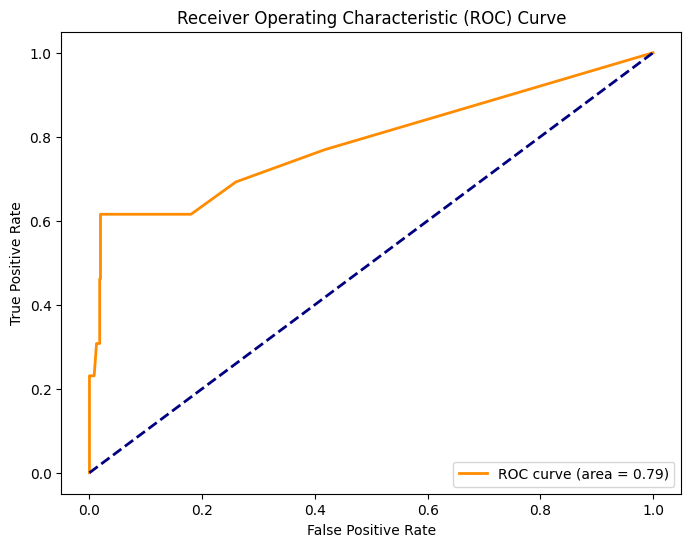

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('C:\\Users\\VikA\\Desktop\\интерсив\\valid.csv')

# Предварительный анализ данных
print(df.head())
print(df.info())

# Удаление строковых столбцов (если они не нужны)
df = df.select_dtypes(include=['number'])

# Если нужно сохранить строковые столбцы, можно их закодировать
# Например, используем LabelEncoder для кодирования строковых значений
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Выбор признаков и целевой переменной
X = df.drop(columns=['target'])  # Удаляем целевую переменную
y = df['target']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятности для класса 1

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Подробная оценка модели
print(classification_report(y_test, y_pred))

# Вычисление ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Построение графика ROC-AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

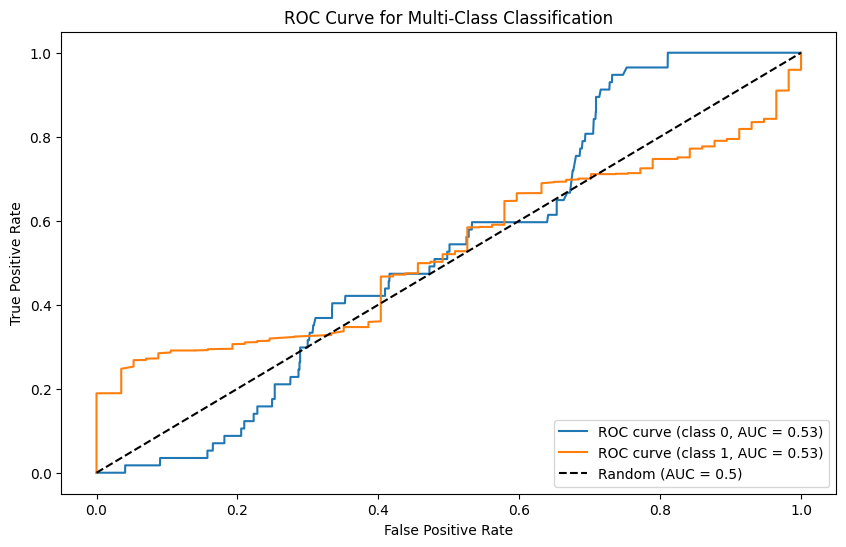

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.98      1.00      0.99      3443

    accuracy                           0.98      3500
   macro avg       0.49      0.50      0.50      3500
weighted avg       0.97      0.98      0.98      3500

Confusion Matrix:
[[   0   57]
 [   0 3443]]


c:\Users\VikA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\VikA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\VikA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных
train_data = pd.read_csv('C:\\Users\\VikA\\Desktop\\интерсив\\cleaned_data.csv') 
valid_data = pd.read_csv('C:\\Users\\VikA\\Desktop\\интерсив\\cleaned_valid.csv') 

# Выбор признаков и целевой переменной
X_train = train_data.drop(columns=['Купоено/Не куплено', 'Уникальный идентификатор покупки'])  # Удаляем ненужные столбцы 
y_train = train_data['Купоено/Не куплено'] 

X_valid = valid_data.drop(columns=['Купоено/Не куплено', 'Уникальный идентификатор покупки'])  # Удаляем ненужные столбцы 
y_valid = valid_data['Купоено/Не куплено']

# Преобразование задачи регрессии в задачу классификации
# Разделение на категории (например, низкая, средняя, высокая сумма)
bins = [0, 100, 500, np.inf]  # Пример разбиения на категории
labels = [0, 1, 2]  # Метки для категорий
y_train_cat = pd.cut(y_train, bins=bins, labels=labels)  # Используем y_train вместо y
y_valid_cat = pd.cut(y_valid, bins=bins, labels=labels)  # Используем y_valid вместо y

# Преобразование категорий в числа
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_cat)
y_valid_encoded = le.transform(y_valid_cat)

# Масштабирование данных (необязательно для Random Forest, но может помочь)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# Определение параметров модели для классификации
model = RandomForestClassifier(
    n_estimators=100,  # Количество деревьев
    max_depth=5,  # Максимальная глубина деревьев
    random_state=42  # Фиксируем случайные состояния
)

# Обучение модели
model.fit(X_train, y_train_encoded)

# Предсказание вероятностей для тестовых данных
y_pred_proba = model.predict_proba(X_valid)

# Построение кривой ROC для каждого класса
n_classes = len(np.unique(y_train_encoded))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # Вычисление FPR и TPR для каждого класса
    fpr[i], tpr[i], _ = roc_curve((y_valid_encoded == i).astype(int), y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение графика AUC-ROC
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}, AUC = {roc_auc[i]:.2f})')

# Добавление диагональной линии для сравнения
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

# Преобразование вероятностей в предсказанные классы
y_pred = np.argmax(y_pred_proba, axis=1)

# Вывод отчета классификации
print("Classification Report:")
print(classification_report(y_valid_encoded, y_pred))

# Вывод матрицы ошибок
print("Confusion Matrix:")
print(confusion_matrix(y_valid_encoded, y_pred))

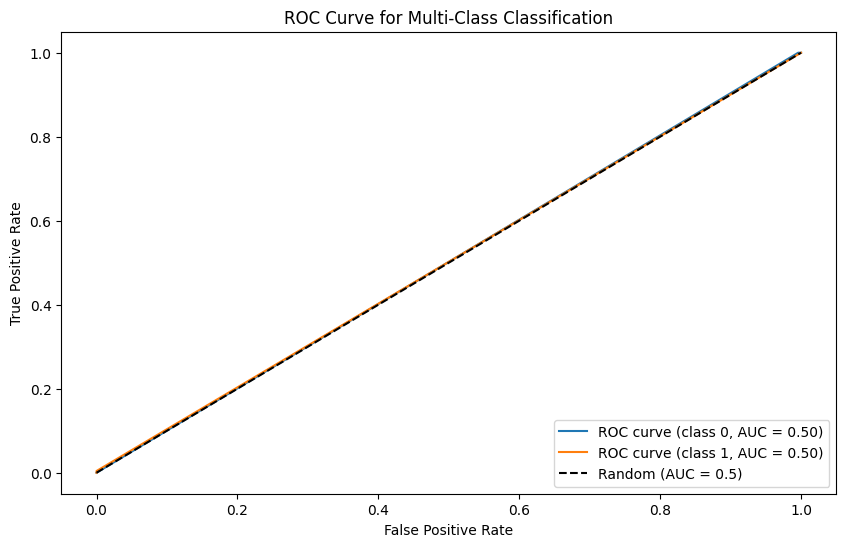

Classification Report:
              precision    recall  f1-score   support

           0       0.02      1.00      0.03        57
           1       1.00      0.00      0.01      3443

    accuracy                           0.02      3500
   macro avg       0.51      0.50      0.02      3500
weighted avg       0.98      0.02      0.01      3500

Confusion Matrix:
[[  57    0]
 [3429   14]]


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных
train_data = pd.read_csv('C:\\Users\\VikA\\Desktop\\интерсив\\cleaned_data.csv') 
valid_data = pd.read_csv('C:\\Users\\VikA\\Desktop\\интерсив\\cleaned_valid.csv') 

# Выбор признаков и целевой переменной
X_train = train_data.drop(columns=['Купоено/Не куплено', 'Уникальный идентификатор покупки'])  # Удаляем ненужные столбцы 
y_train = train_data['Купоено/Не куплено'] 

X_valid = valid_data.drop(columns=['Купоено/Не куплено', 'Уникальный идентификатор покупки'])  # Удаляем ненужные столбцы 
y_valid = valid_data['Купоено/Не куплено']

# Преобразование задачи регрессии в задачу классификации
# Разделение на категории (например, низкая, средняя, высокая сумма)
bins = [0, 100, 500, np.inf]  # Пример разбиения на категории
labels = [0, 1, 2]  # Метки для категорий
y_train_cat = pd.cut(y_train, bins=bins, labels=labels)  # Используем y_train вместо y
y_valid_cat = pd.cut(y_valid, bins=bins, labels=labels)  # Используем y_valid вместо y

# Преобразование категорий в числа
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_cat)
y_valid_encoded = le.transform(y_valid_cat)

# Масштабирование данных (обязательно для SVC, так как он чувствителен к масштабу данных)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# Определение параметров модели для классификации
model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))

# Обучение модели
model.fit(X_train, y_train_encoded)

# Предсказание вероятностей для тестовых данных
y_pred_proba = model.predict_proba(X_valid)

# Построение кривой ROC для каждого класса
n_classes = len(np.unique(y_train_encoded))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # Вычисление FPR и TPR для каждого класса
    fpr[i], tpr[i], _ = roc_curve((y_valid_encoded == i).astype(int), y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение графика AUC-ROC
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}, AUC = {roc_auc[i]:.2f})')

# Добавление диагональной линии для сравнения
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

# Преобразование вероятностей в предсказанные классы
y_pred = np.argmax(y_pred_proba, axis=1)

# Вывод отчета классификации
print("Classification Report:")
print(classification_report(y_valid_encoded, y_pred))

# Вывод матрицы ошибок
print("Confusion Matrix:")
print(confusion_matrix(y_valid_encoded, y_pred))